Import frames and train, test, evaluate network on facial images

# Importing Dependencies

In [1]:
from display import pltDisplay
from pathlib import Path
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from sorting import human_sort
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow.keras.backend as K
# import IPython.display as ipd


import constants as const
import csv
import cv2
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
# import tensorflow.keras.backend as K
import time
import utils
import subprocess

from keras_vggface.vggface import VGGFace
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_imagenet
from keras_vggface.utils import preprocess_input as preprocess_vggface

import mlflow
import gc

Set Mlflows parameters to record model parameters offline/online

In [2]:
mlflow_params = {
    'local': True,
    'host': '127.0.0.1',
    'port': '8080'
}
if (mlflow_params['local']):
    # Start server
    mlflow_server_process = subprocess.Popen(
        f"mlflow server --host {mlflow_params['host']} --port {mlflow_params['port']}",
        shell=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
    mlflow.set_experiment("Frames")
else:
    # https://www.mlflow.org/docs/latest/getting-started/tracking-server-overview/index.html
    # Host: https://community.cloud.databricks.com/
    mlflow.login()
    mlflow.set_tracking_uri(uri="databricks")
    mlflow.set_experiment("/Frames")

mlflow.tensorflow.autolog(
    log_models=False,
    log_datasets=True,
    log_input_examples=True,
    log_model_signatures=True,
    checkpoint=False
)

In [24]:
# Run the garbage collector
def clear_gpu():
    gc.collect()

In [25]:
# Print system info
utils.system_info()


    Windows:
        Version: 10.0 build 19045
    Python:
        Version: 3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
        Path: C:\Users\mic-c\anaconda3\envs\opencv_contrib_env\python.exe
    


In [26]:
# Print modules info
utils.modules_info()


    OpenCV:
        Version: 4.9.0
    Tensorflow:
        Version: 2.10.1
    


In [27]:
log_file = Path(const.logs_path, 'FACER.log')
logging.basicConfig(
    format='%(asctime)s %(message)s',
    filemode='a',
    filename=log_file,
    encoding='utf-8',
    level=logging.INFO,
    force=True
)

# Import Dataset

In [28]:
data_df = pd.read_csv(Path(const.csv_path, 'dataset.csv'))

# Frame

## Prepare Data

### Dataset Creation for ML

In [29]:
IMG_WIDTH = IMG_HEIGHT = 224
IMG_CHANNELS = 3
SEED = 42
BATCH_SIZE = 2
VALIDATION_SPLIT = 0.2
EMOTIONS_LABELS = const.EMOTIONS_LABELS  # RAVDESS emotion labels

In [30]:
TOTAL_ELEMENTS = const.DATASET_TOTAL_ELEMENTS
print(f'Total frames: {TOTAL_ELEMENTS}')

Total frames: 158262


In [31]:
label_names = const.EMOTIONS_LABELS_SORTED.copy()

label_names_gender = []
for em in label_names:
    label_names_gender.append(em + '_female')
    label_names_gender.append(em + '_male')

#### Dataset Creation

In [32]:
actors_labels = [f'{i:02d}' for i in range(1, 25)]
dist_idxs = {
    '1': [slice(0, 16), slice(16, 20), slice(20, 24)],
    '2': [slice(8, 24), slice(4, 8), slice(0, 4)],
    '3': [slice(4, 20), slice(20, 24), slice(0, 4)]
}

In [33]:
# Split actors in train, validation, test
dist_n = 1
train_idxs, val_idxs, test_idxs = [actors_labels[i] for i in dist_idxs[str(dist_n)]]

print(train_idxs, val_idxs, test_idxs)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16'] ['17', '18', '19', '20'] ['21', '22', '23', '24']


In [34]:
def preprocess_image(image, preprocess_type=None):
    if (preprocess_type == 'Imagenet'):
        image = preprocess_imagenet(image)
    elif (preprocess_type == 'VGGFace'):
        image = preprocess_vggface(image, version=1)
    image = image / 255

    return image

In [35]:
def prep_external_image(filename, preprocess_type=None):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS, fancy_upscaling=False)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return preprocess_image(image, preprocess_type)

In [36]:
def make_dataset(path, actors_idx, talk_frame=False, acted_frame=False,
                 undersampling=False, preprocess_vgg=True, shuffle=False,
                 gender_classes=False, sampling=1):

    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        if (preprocess_vgg == 'Imagenet'):
            image = preprocess_imagenet(image)
        elif (preprocess_vgg == 'VGGFace'):
            image = preprocess_vggface(image, version=1)

        image = image / 255

        return image

    filenames = []
    talk_regex = '*-01.jpg' if talk_frame else '*.jpg'
    acted_regex = '02' if acted_frame else '*'
    gen_regex = f'*-*-*-{acted_regex}-*-*-*-{talk_regex}'

    file_dict = dict()
    file_dict_gender = dict()

    for label in sorted(label_names):
        file_dict[label] = []

    for label in sorted(label_names_gender):
        file_dict_gender[label] = []


    for label in label_names:
        for actor in actors_idx:
            for file in Path(path, label, actor).glob(f'{gen_regex}'):
                gender = utils.get_gender(str(file))[1]
                lab = label + f'_{gender}'
                file_dict_gender[lab].append(str(file))
                file_dict[label].append(str(file))

    arr_len = [len(arr) for arr in file_dict.values()]

    if undersampling:
        filenames = [arr[:min(arr_len)] for arr in file_dict.values()]
    else:
        filenames = [arr for arr in file_dict.values()]

    filenames = sum(filenames, [])

    if shuffle:
        random.Random(SEED).shuffle(filenames)

    labels = []

    if (gender_classes):

        for elem in filenames:
            cl = utils.get_class_string(str(elem))
            gender = utils.get_gender(str(elem))[1]
            lab = cl + f'_{gender}'
            labels.append(label_names_gender.index(lab))
    else:
        labels = [
            label_names.index(EMOTIONS_LABELS[int(utils.get_class(elem)) - 1])
            for elem in filenames
        ]

    if (sampling < 1):
        filenames, _, labels, _ = train_test_split(
            filenames, labels, train_size=sampling, random_state=SEED
        )

    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    images_ds = filenames_ds.map(
        parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds = tf.data.Dataset.zip((images_ds, labels_ds))

    return [ds, filenames]

In [37]:
sampling_rate = 0.1
gender_classes = False
talk_frame = True
acted_frame = True
preprocess_vgg = False  # False, Imagenet or VGGFace

if (acted_frame):
    # There are no strong neutral frames
    print('Removing "neutral" frames')
    if 'neutral' in label_names:
        label_names.remove('neutral')
    if 'neutral_female' in label_names_gender:
        label_names_gender.remove('neutral_female')
    if 'neutral_male' in label_names_gender:
        label_names_gender.remove('neutral_male')

NUM_CLASSES = len(label_names_gender) if gender_classes else len(label_names)

train_ds, train_files = make_dataset(
    const.frames_path, train_idxs, talk_frame=talk_frame, acted_frame=acted_frame,
    preprocess_vgg=preprocess_vgg, shuffle=True, gender_classes=gender_classes,
    sampling=sampling_rate
)

val_ds, val_files = make_dataset(
    const.frames_path, val_idxs, talk_frame=talk_frame, acted_frame=acted_frame,
    preprocess_vgg=preprocess_vgg, gender_classes=gender_classes,
    sampling=sampling_rate
)

test_ds, test_files = make_dataset(
    const.frames_path, test_idxs, talk_frame=talk_frame, acted_frame=acted_frame,
    preprocess_vgg=preprocess_vgg, gender_classes=gender_classes,
    sampling=sampling_rate
)

labels = label_names if not gender_classes else label_names_gender

Removing "neutral" frames


In [38]:
assert len(train_ds) == len(train_files), len(train_files)
assert len(val_ds) == len(val_files), len(val_files)
assert len(test_ds) == len(test_files), len(test_files)

In [39]:
train_ds_elements = len(train_ds)
test_ds_elements = len(test_ds)
val_ds_elements = len(val_ds)

In [40]:
print(f'train_ds samples: {train_ds_elements}')
print(f'test_ds samples: {test_ds_elements}')
print(f'val_ds samples: {val_ds_elements}')

train_ds samples: 3316
test_ds samples: 878
val_ds samples: 886


### Image Augmentation

In [41]:
trainAug = Sequential([
    # preprocessing.Rescaling(scale=1.0 / 255),
    preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomZoom(
    #     height_factor=(-0.05, -0.15),
    #     width_factor=(-0.05, -0.15)),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomRotation(0.05)
])

In [42]:
def augment_using_ops(images, labels):
    images = tf.image.random_brightness(images, 0.2)
    # images = tf.image.stateless_random_brightness(images, 0.2, SEED)
    # images = tf.image.stateless_random_contrast(images, 0.2, 0.5, SEED)
    # images = tf.image.stateless_random_flip_left_right(images, SEED)
    # images = tf.image.stateless_random_hue(images, 0.2, SEED)
    # images = tf.image.stateless_random_saturation(images, 0.5, 1.0, SEED)

    return (images, labels)

#### Frame distribution of dataset (Train / Val)

##### Train

In [179]:
train_matrix = np.zeros((len(labels), len(train_idxs)), dtype=int)
for i in train_files:
    parents = Path(i).relative_to('Generated/Frames/').parents[0].parts
    em_idx = labels.index(parents[0])
    act = train_idxs.index(parents[1])
    train_matrix[em_idx][act] += 1

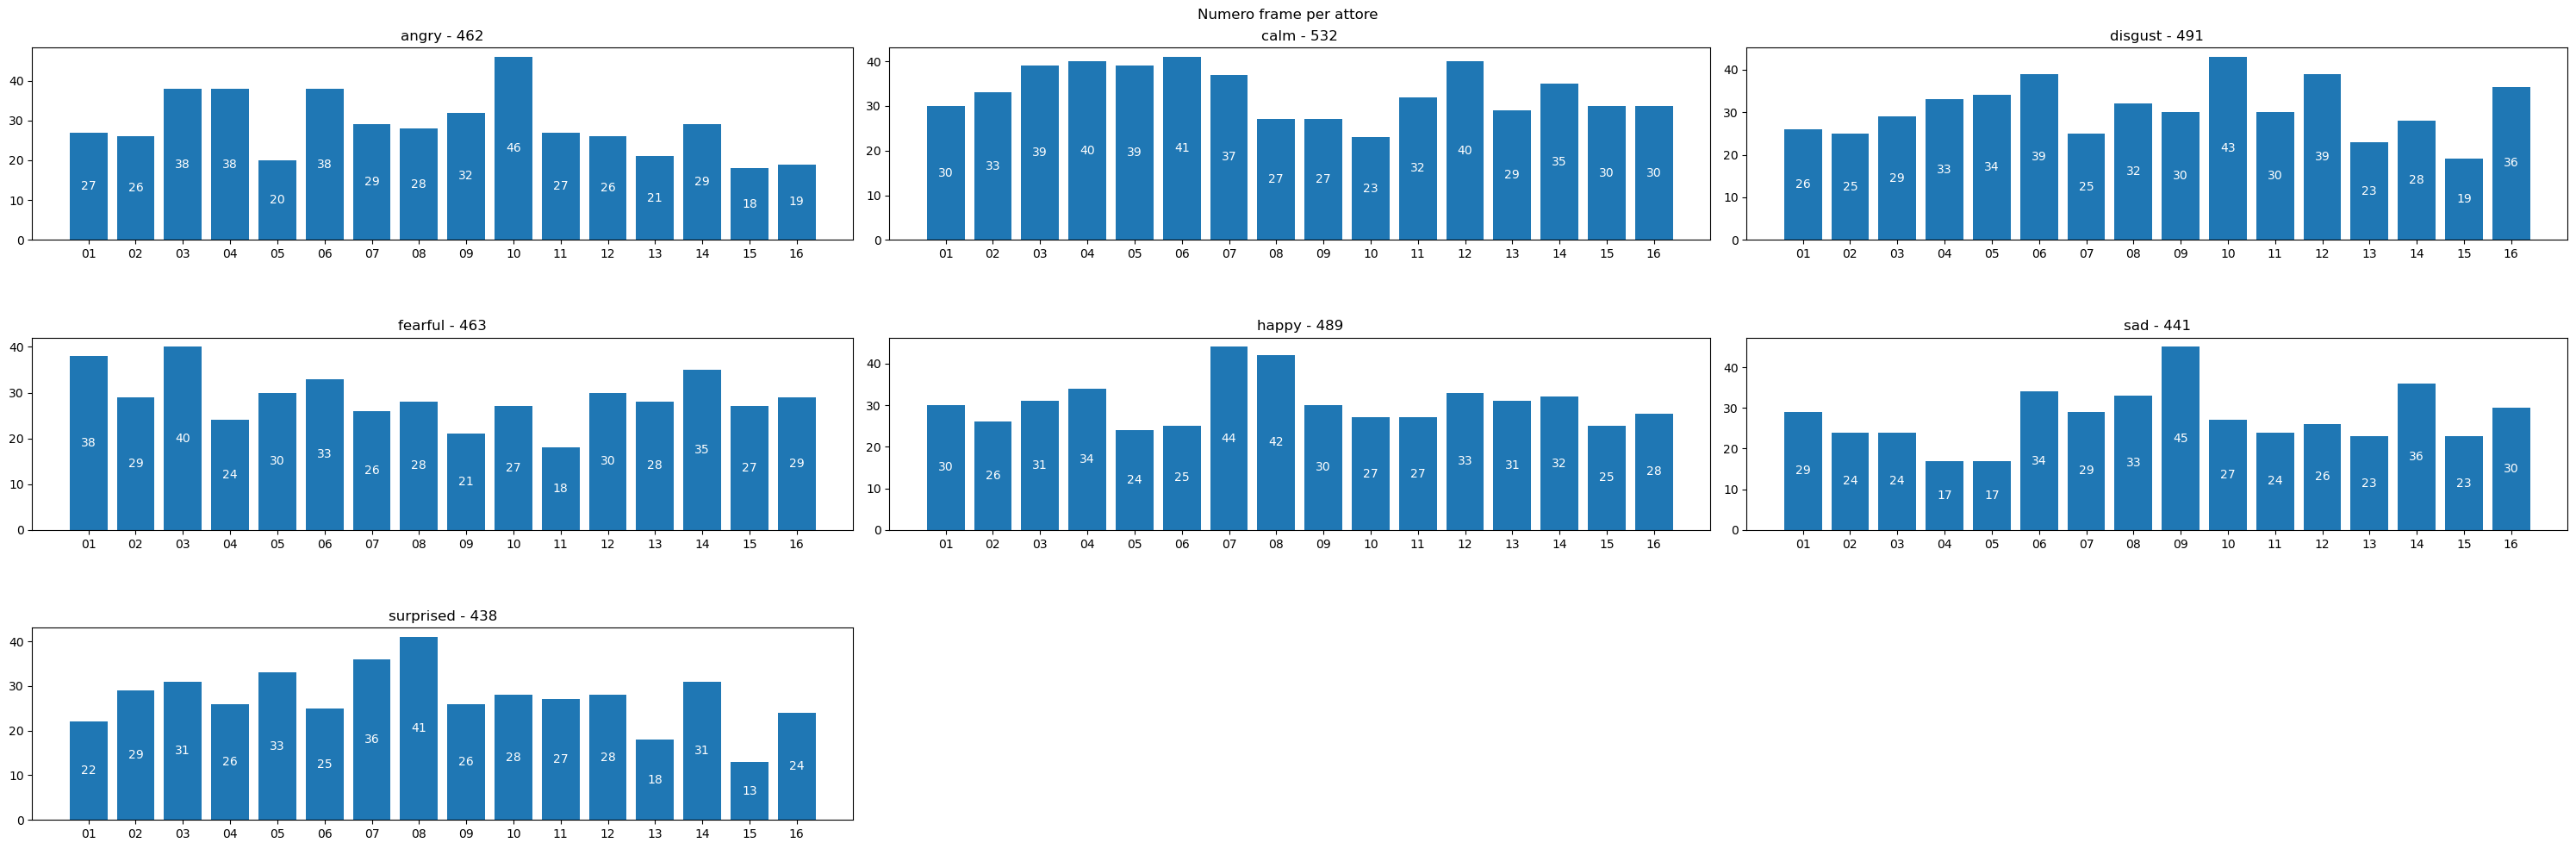

In [165]:
mod = labels

plt.figure(figsize=(30, 10))
plt.axis('off')
plt.suptitle('Numero frame per attore')
cols = 3
rows = int(np.ceil(len(mod) / cols))

for idx, i in enumerate(train_matrix):

    plt.subplot(rows, cols, idx + 1)
    x_mod = train_idxs
    y_mod = train_matrix[idx]
    bar_plot = plt.bar(x_mod, y_mod)
    plt.title(f'{mod[idx]} - {np.sum(y_mod)}')
    plt.bar_label(bar_plot, label_type='center', color='white')
    plt.tight_layout(h_pad=5)

In [167]:
img_per_actor = [train_matrix[:, idx] for idx in range(len(train_idxs))]

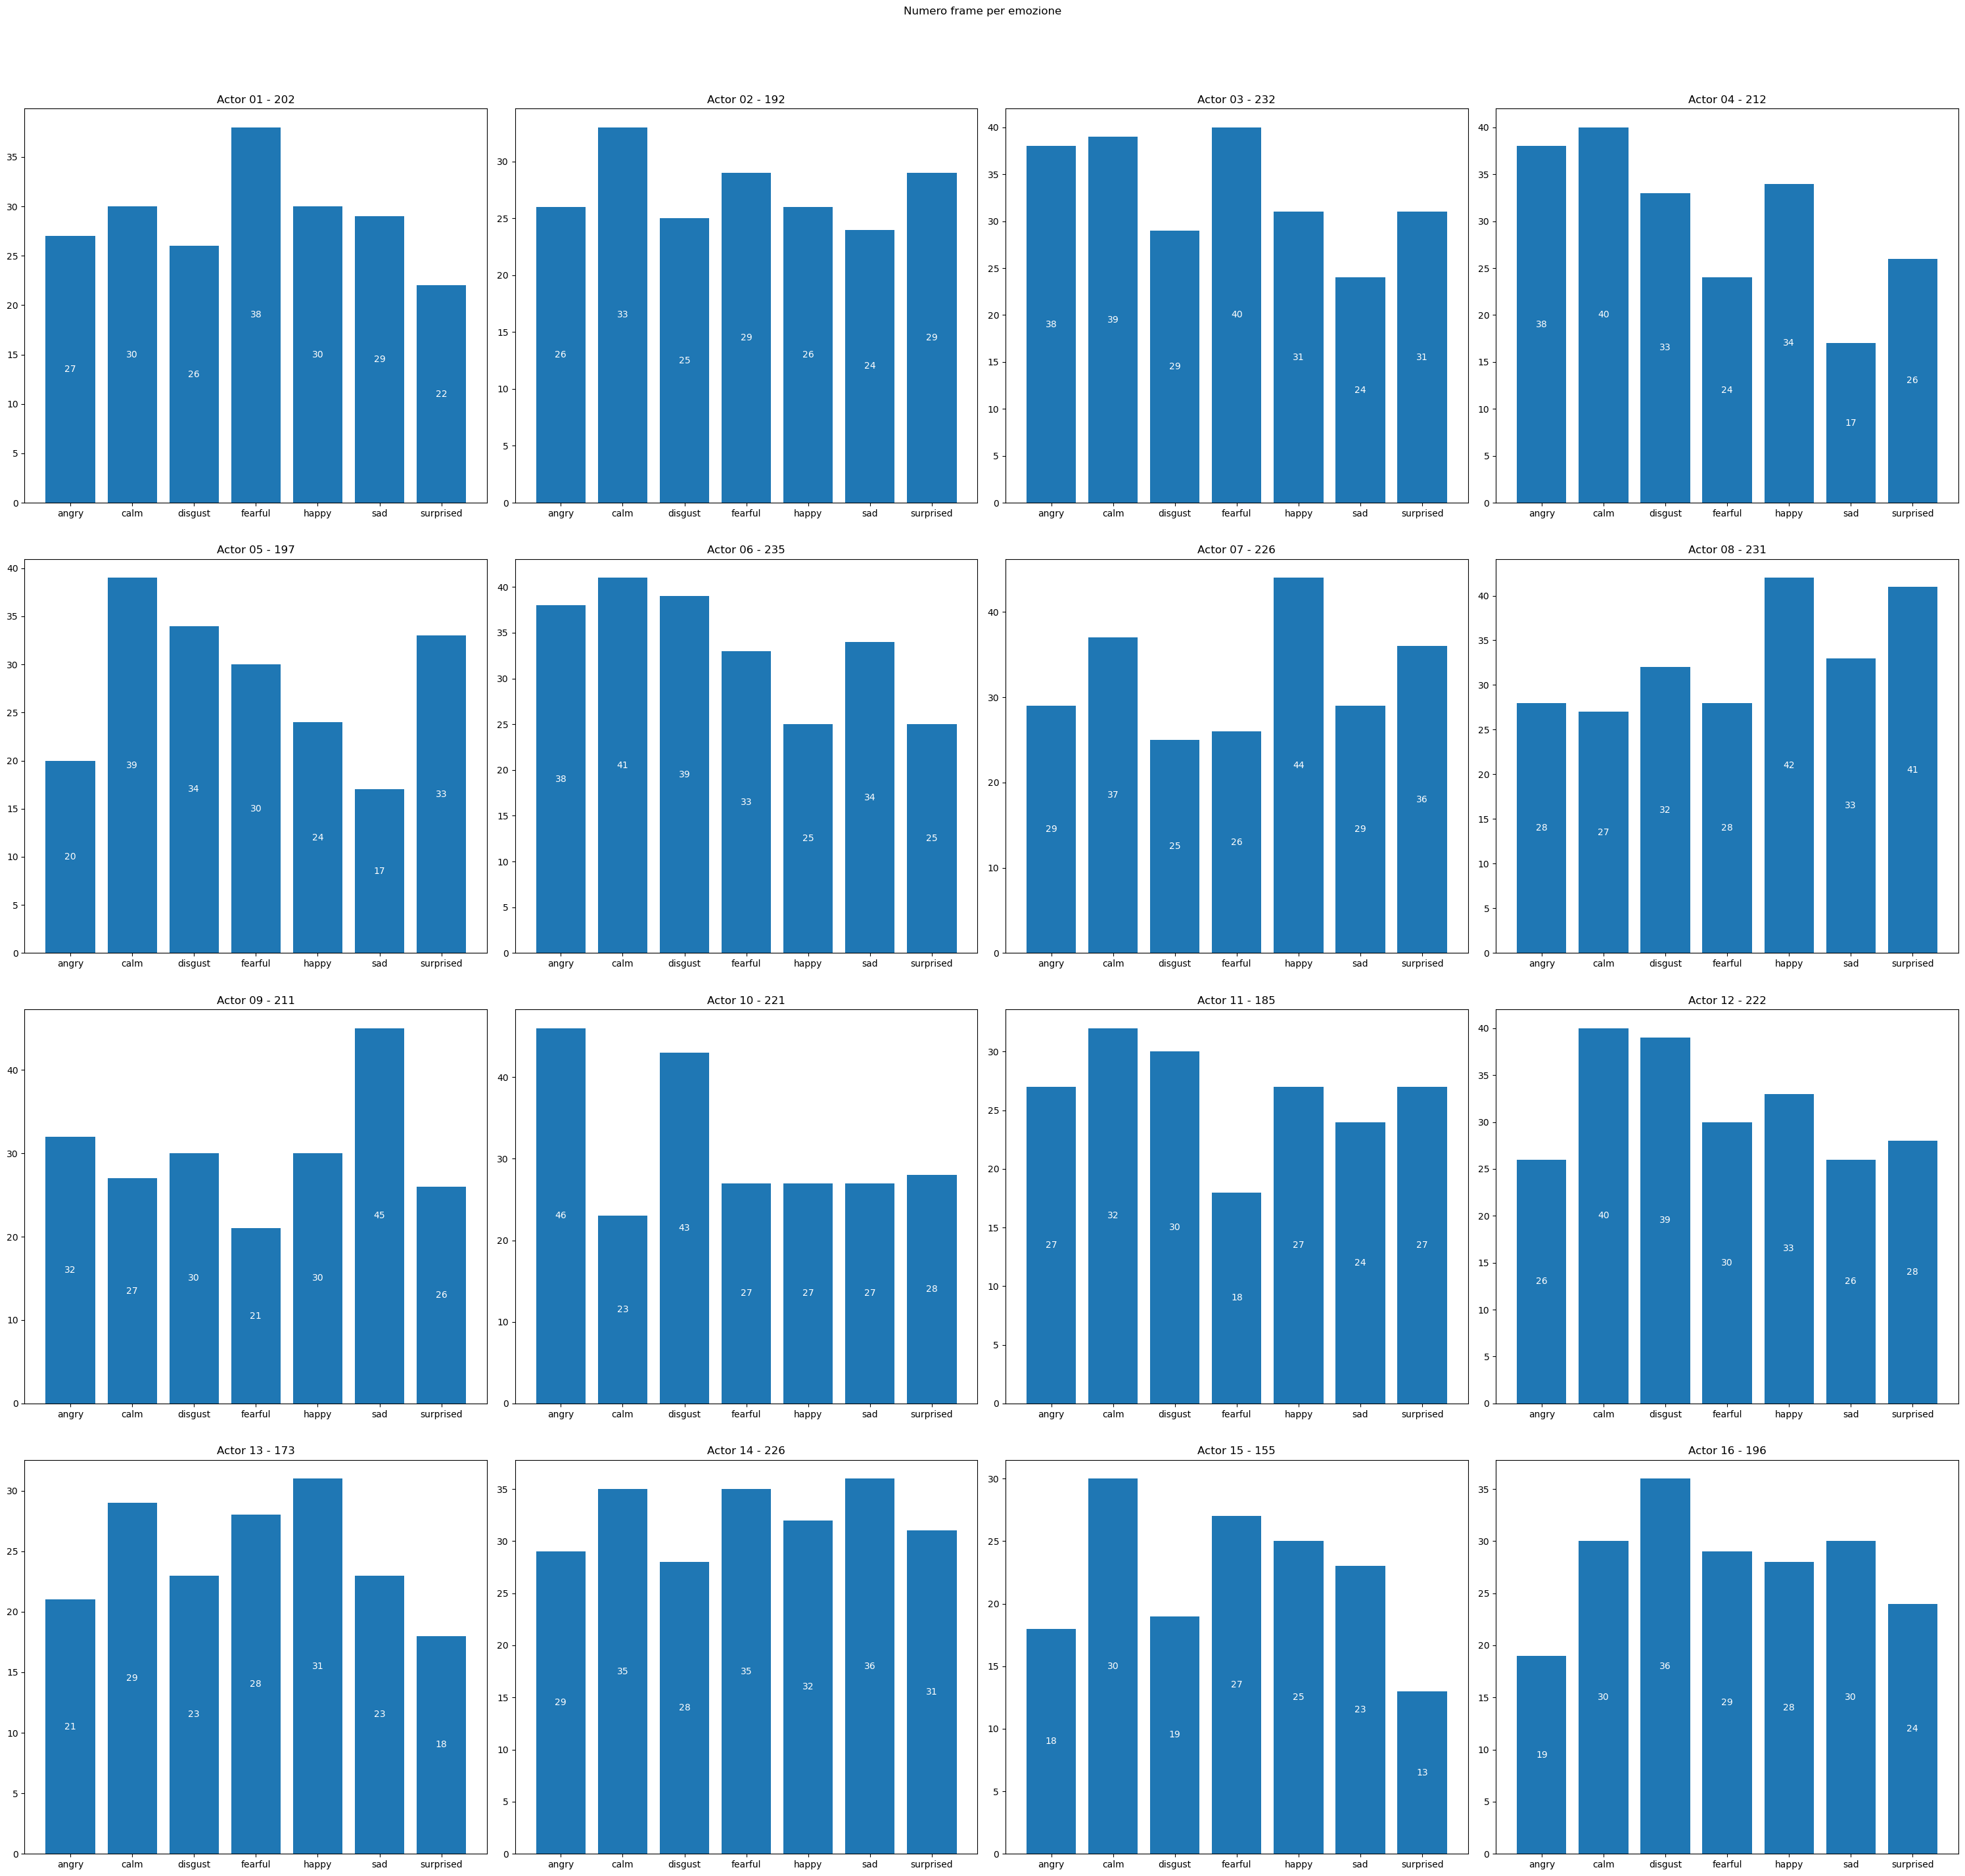

In [170]:
# Frames per Emotion Distribution Graph
mod = labels

plt.figure(figsize=(30, 30))
plt.axis('off')
plt.suptitle('Numero frame per emozione')
cols = 4
rows = int(np.ceil(len(train_idxs) / 4))

# n = rows * cols
for idx, i in enumerate(train_idxs):

    plt.subplot(rows, cols, idx + 1)
    x_mod = mod
    y_mod = img_per_actor[idx]
    bar_plot = plt.bar(x_mod, y_mod)
    plt.title(f'Actor {i} - {np.sum(y_mod)}')
    plt.bar_label(bar_plot, label_type='center', color='white')
    plt.tight_layout(h_pad=3, rect=[0, 0.03, 1, 0.95])

##### Validation

In [180]:
val_matrix = np.zeros((len(labels), len(val_idxs)), dtype=int)
for i in val_files:
    parents = Path(i).relative_to('Generated/Frames/').parents[0].parts
    em_idx = labels.index(parents[0])
    act = val_idxs.index(parents[1])
    val_matrix[em_idx][act] += 1

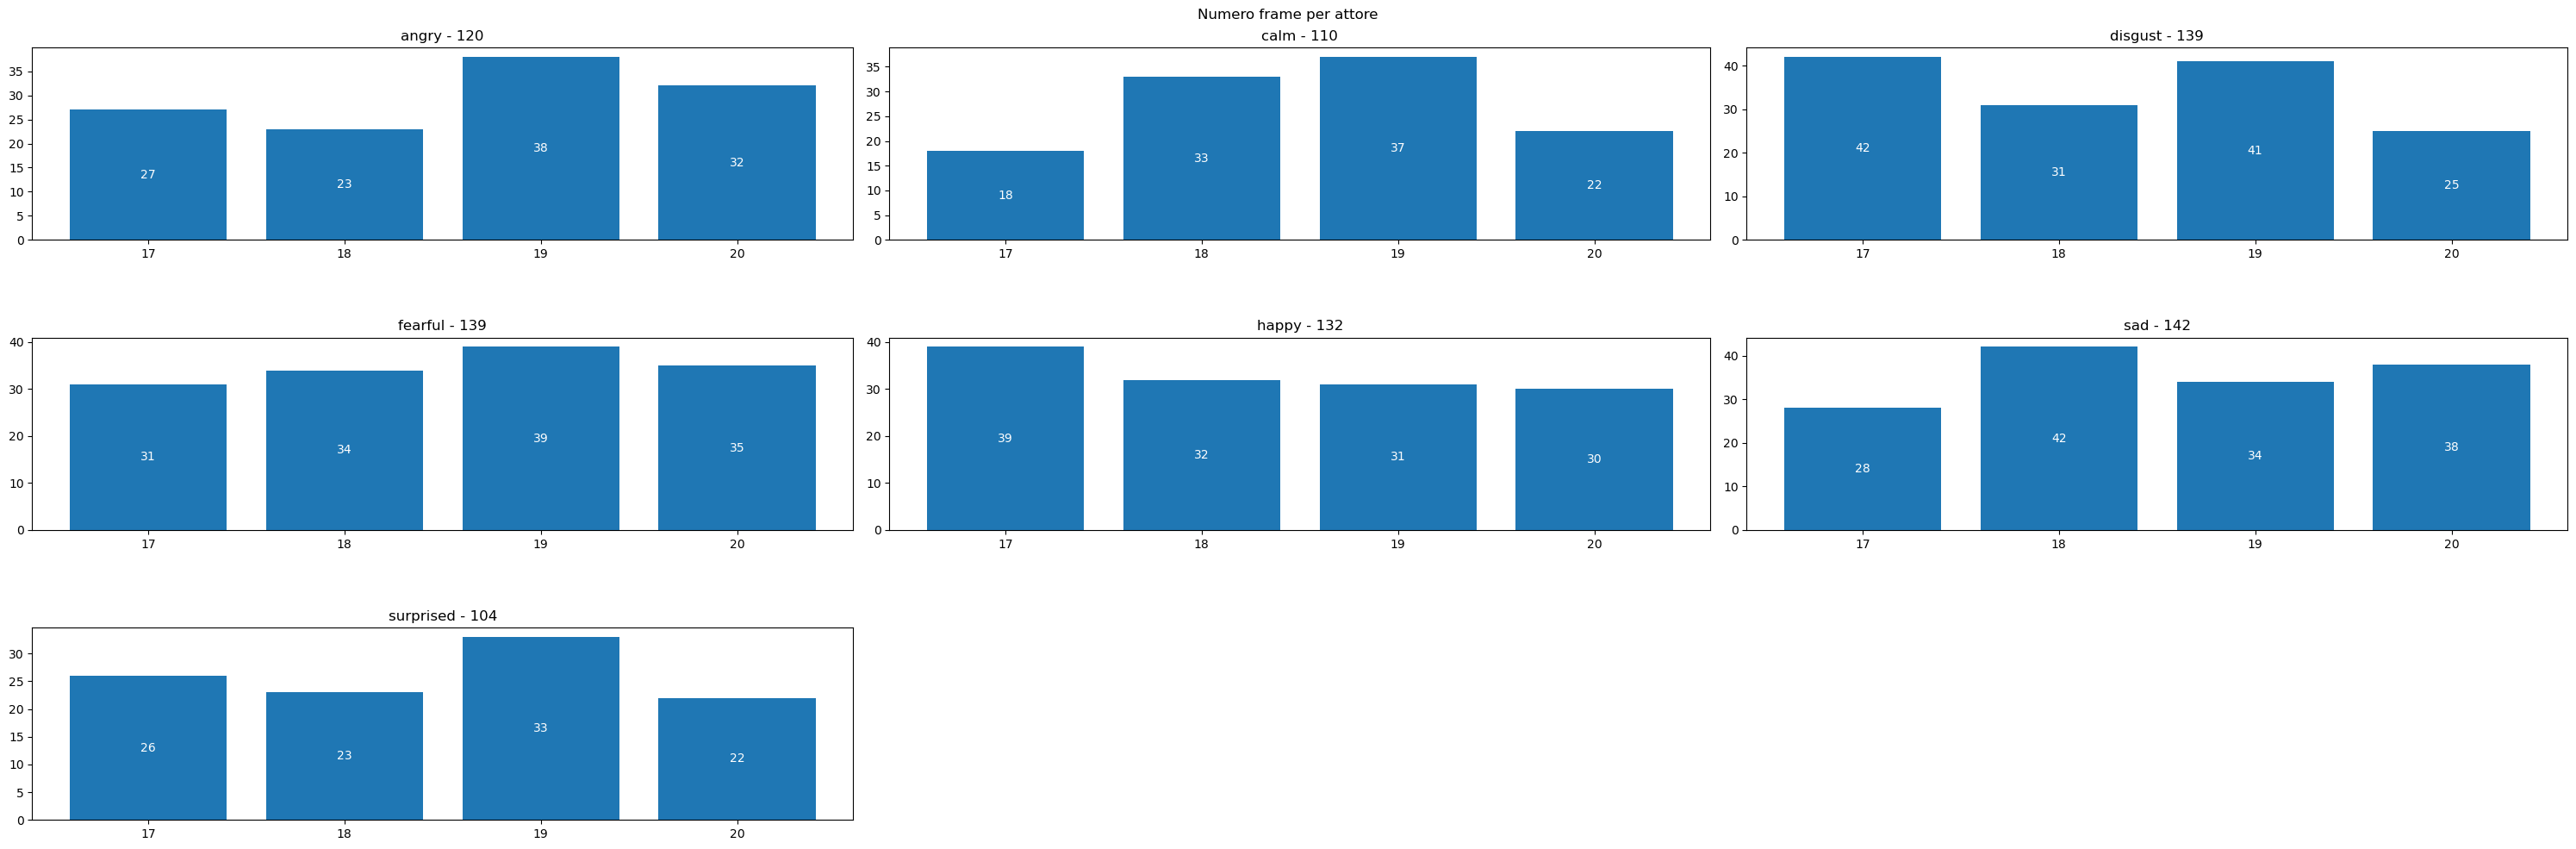

In [181]:
mod = labels

plt.figure(figsize=(30, 10))
plt.axis('off')
plt.suptitle('Numero frame per attore')
cols = 3
rows = int(np.ceil(len(mod) / cols))

for idx, i in enumerate(val_matrix):

    plt.subplot(rows, cols, idx + 1)
    x_mod = val_idxs
    y_mod = val_matrix[idx]
    bar_plot = plt.bar(x_mod, y_mod)
    plt.title(f'{mod[idx]} - {np.sum(y_mod)}')
    plt.bar_label(bar_plot, label_type='center', color='white')
    plt.tight_layout(h_pad=5)

In [182]:
img_per_actor = [val_matrix[:, idx] for idx in range(len(val_idxs))]

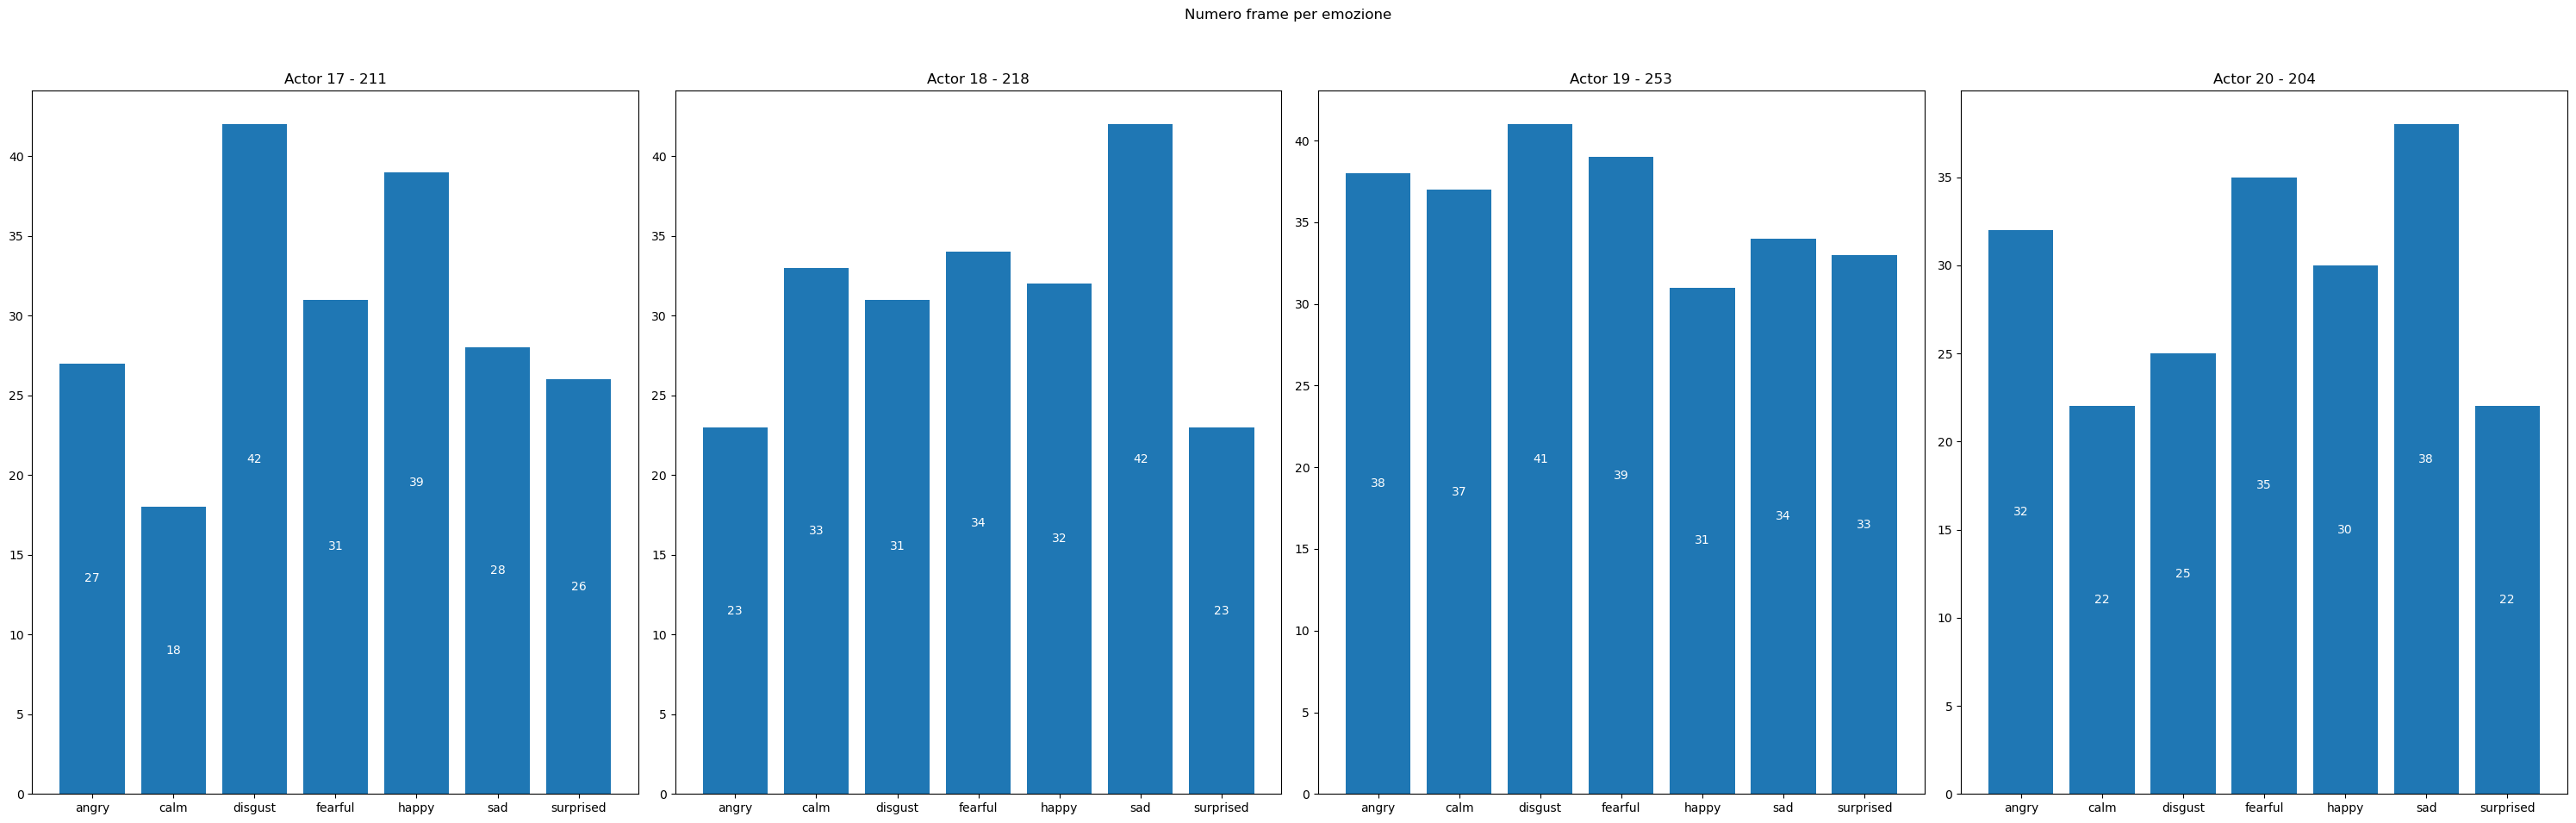

In [186]:
# Frames per Emotion Distribution Graph
mod = labels

plt.figure(figsize=(30, 10))
plt.axis('off')
plt.suptitle('Numero frame per emozione')
cols = 4
rows = int(np.ceil(len(val_idxs) / 4))

# n = rows * cols
for idx, i in enumerate(val_idxs):

    plt.subplot(rows, cols, idx + 1)
    x_mod = mod
    y_mod = img_per_actor[idx]
    bar_plot = plt.bar(x_mod, y_mod)
    plt.title(f'Actor {i} - {np.sum(y_mod)}')
    plt.bar_label(bar_plot, label_type='center', color='white')
    plt.tight_layout(h_pad=3, rect=[0, 0.03, 1, 0.95])

#### Frame distribution of dataset (General)

In [43]:
talk_regex = '*-01.jpg' if talk_frame else '*.jpg'
acted_regex = '02' if acted_frame else '*'

gen_regex = f'*-*-*-{acted_regex}-*-*-*-{talk_regex}'

em_ar = []
for label in const.EMOTIONS_LABELS_SORTED:
    label_ar = []
    for actor in actors_labels:
        label_ar.append(
            len(list(Path(const.frames_path, label, actor).glob(f'{gen_regex}')))
        )
    em_ar.append(label_ar)

em_ar = np.array(em_ar)

# img_per_emotion = np.sum(em_ar, axis=1)
# img_per_actor = np.sum(em_ar, axis=0)
img_total = np.sum(em_ar)

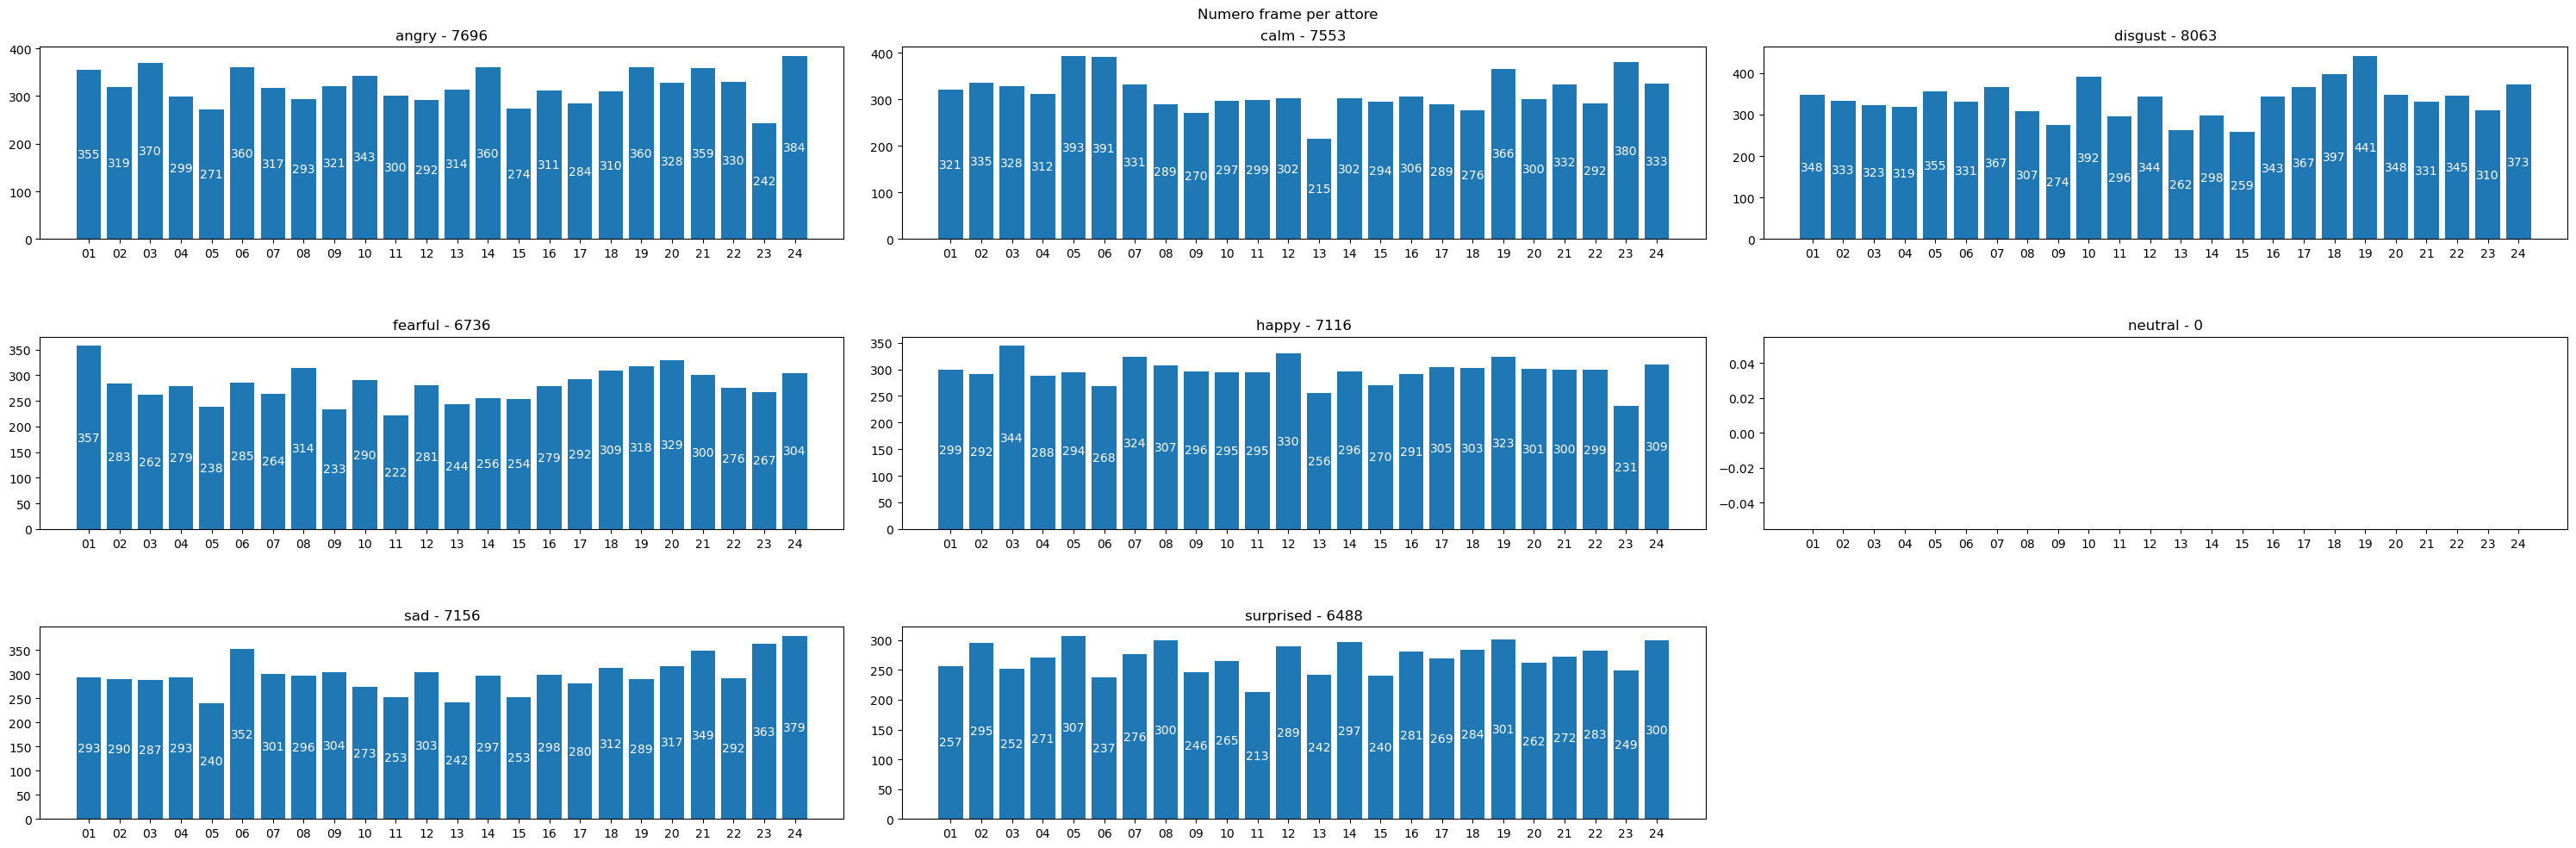

In [44]:
mod = const.EMOTIONS_LABELS_SORTED

plt.figure(figsize=(30, 10))
plt.axis('off')
plt.suptitle('Numero frame per attore')
cols = 3
rows = int(np.ceil(len(mod) / cols))

for idx, i in enumerate(em_ar):

    plt.subplot(rows, cols, idx + 1)
    x_mod = actors_labels
    y_mod = em_ar[idx]
    bar_plot = plt.bar(x_mod, y_mod)
    plt.title(f'{mod[idx]} - {np.sum(y_mod)}')
    plt.bar_label(bar_plot, label_type='center', color='white')
    plt.tight_layout(h_pad=5)

In [45]:
img_per_actor = [em_ar[:, idx] for idx in range(24)]

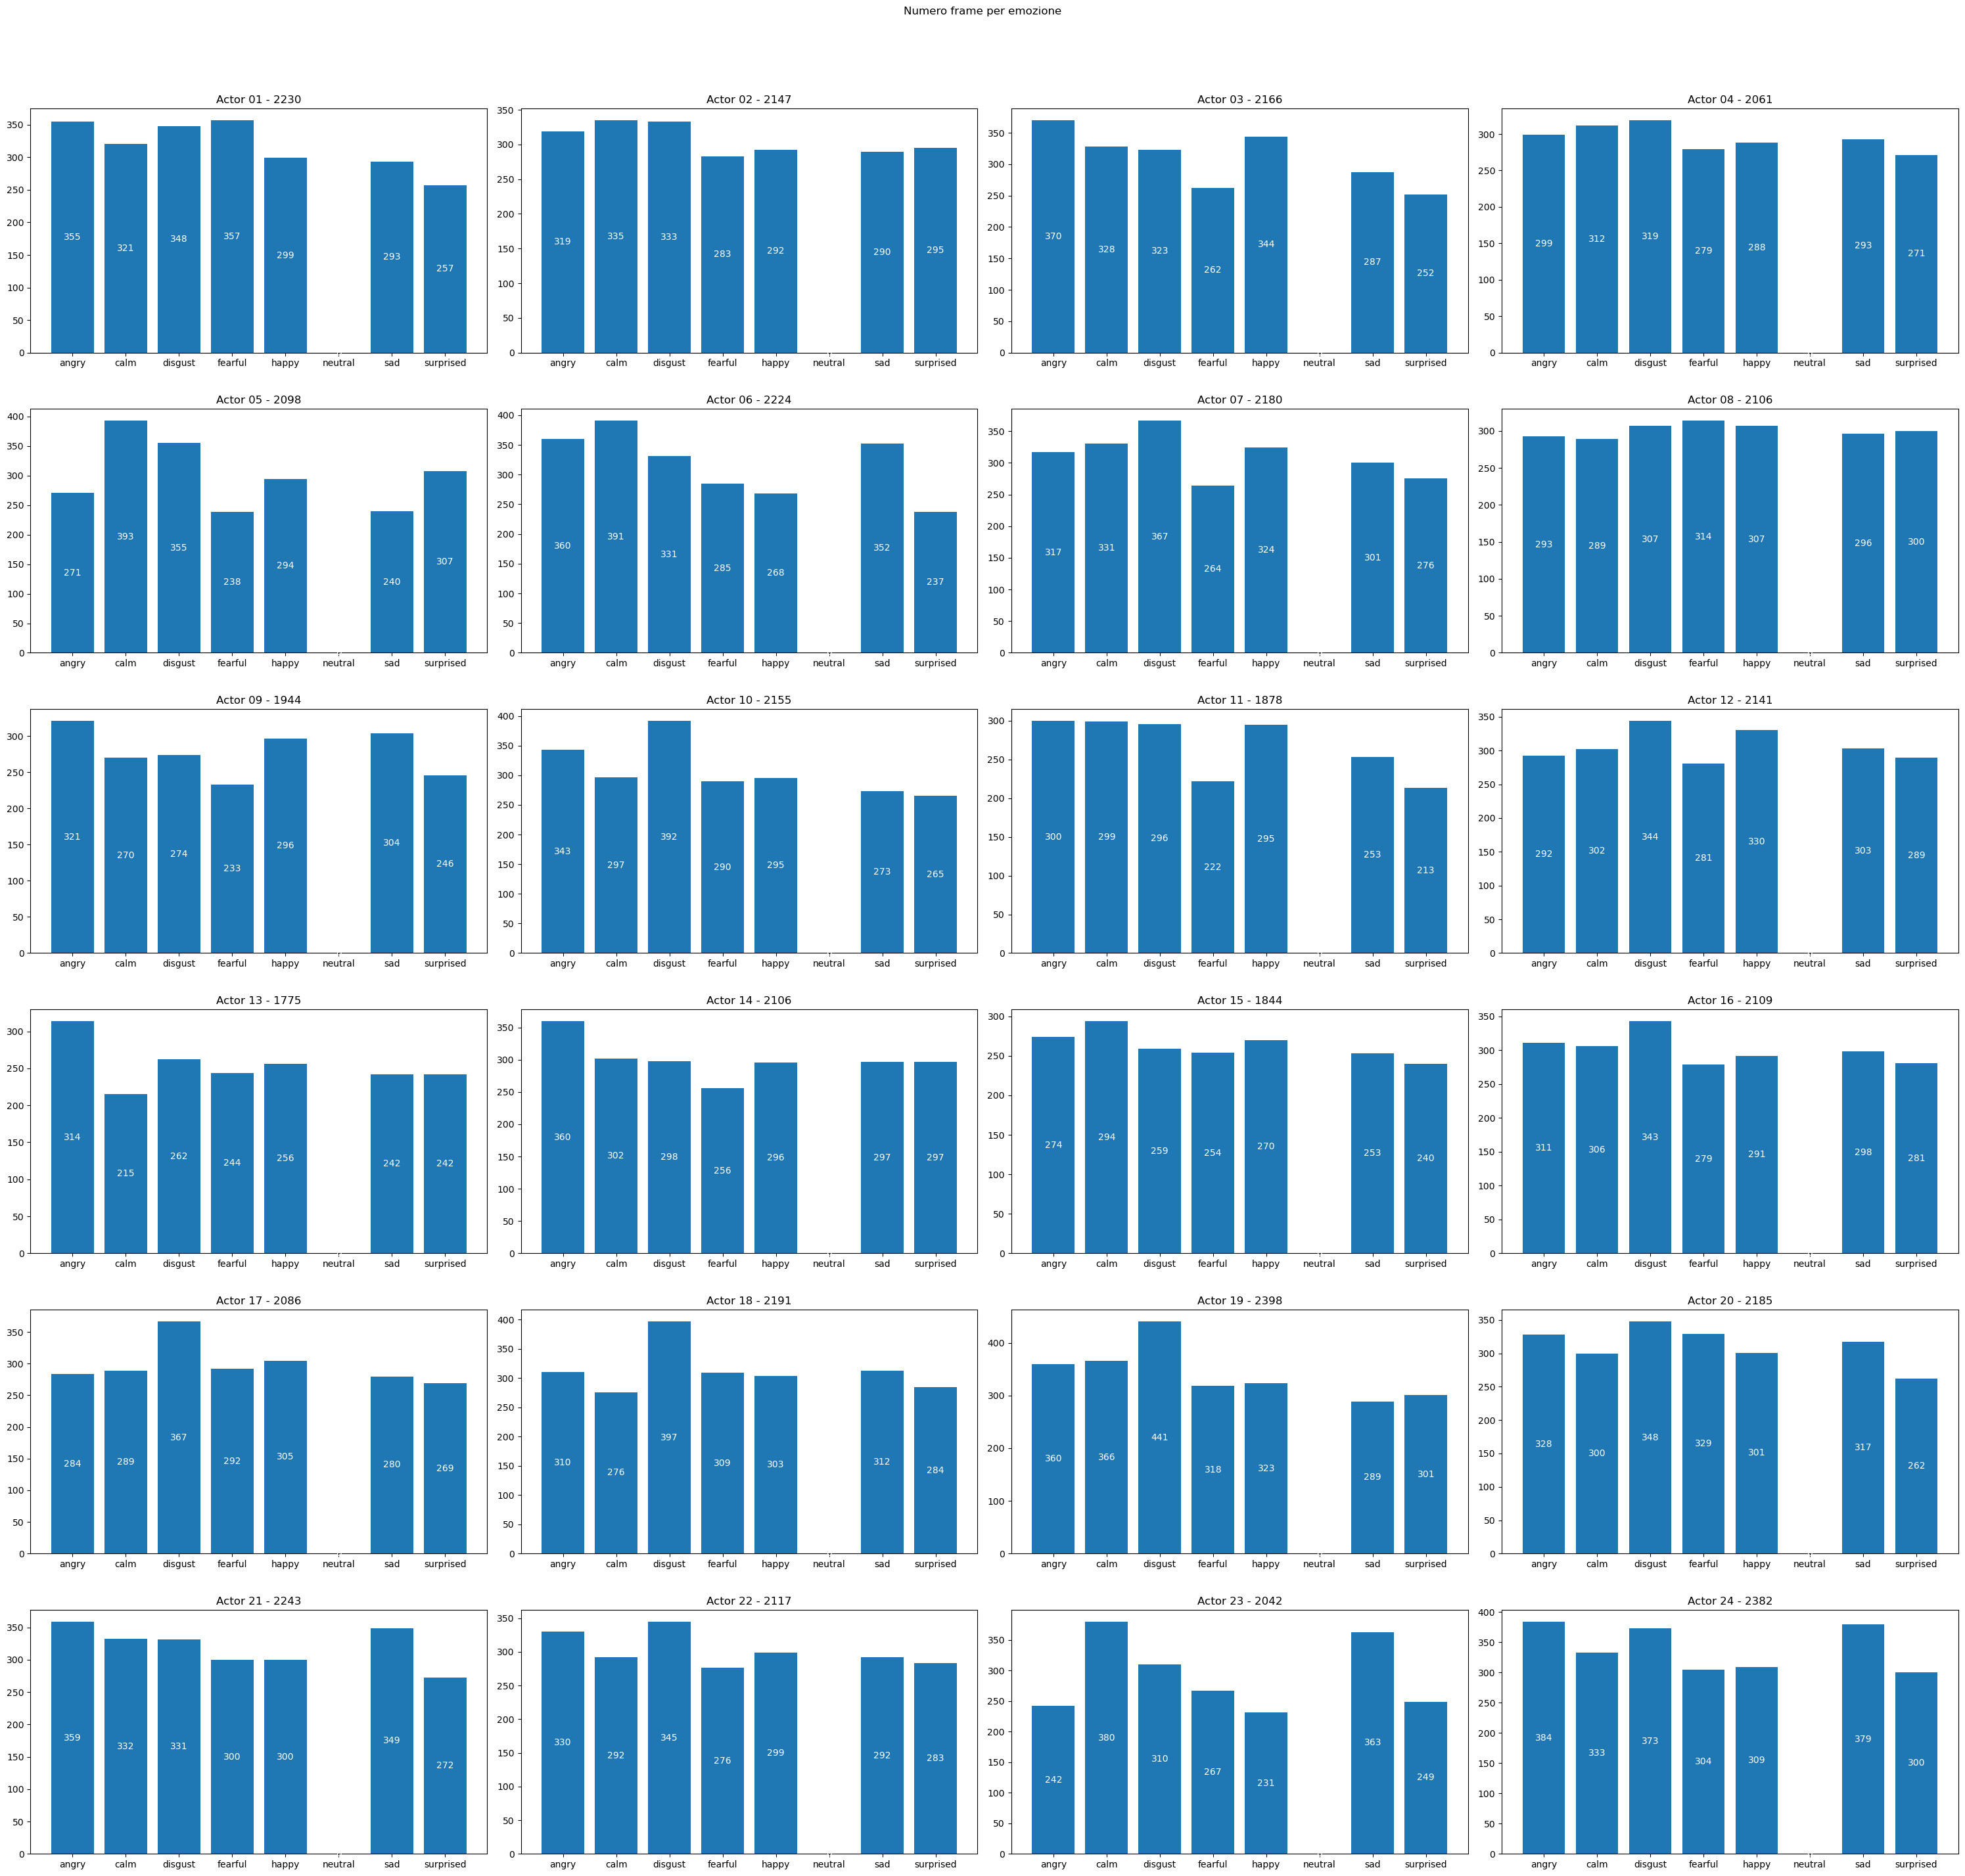

In [46]:
# Frames per Emotion Distribution Graph
mod = const.EMOTIONS_LABELS_SORTED

plt.figure(figsize=(30, 30))
plt.axis('off')
plt.suptitle('Numero frame per emozione')
cols = 4
rows = int(np.ceil(len(actors_labels) / 4))

# n = rows * cols
for idx, i in enumerate(actors_labels):

    plt.subplot(rows, cols, idx + 1)
    x_mod = mod
    y_mod = img_per_actor[idx]
    bar_plot = plt.bar(x_mod, y_mod)
    plt.title(f'Actor {i} - {np.sum(y_mod)}')
    plt.bar_label(bar_plot, label_type='center', color='white')
    plt.tight_layout(h_pad=3, rect=[0, 0.03, 1, 0.95])

## Build and train the model

Add operations to reduce read latency while training the model:

`ds.batch` Combines consecutive elements of the dataset into batches. The components of the resulting element will have an additional outer dimension, which will be *batch_size*

`ds.prefetch` Allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [187]:
def configure_for_performance(ds, batch_size=BATCH_SIZE):

    ds = (
        ds
        .batch(batch_size)
        # .cache()
        # .shuffle(buffer_size=1000)
        # .repeat()
        # .map(lambda x, y: (trainAug(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        # .map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return ds

In [188]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [189]:
for example_images, example_labels in train_ds.take(1):
    print(example_images.shape)
    print(example_labels.shape)

(2, 224, 224, 3)
(2,)


In [195]:
int(2.6)

2

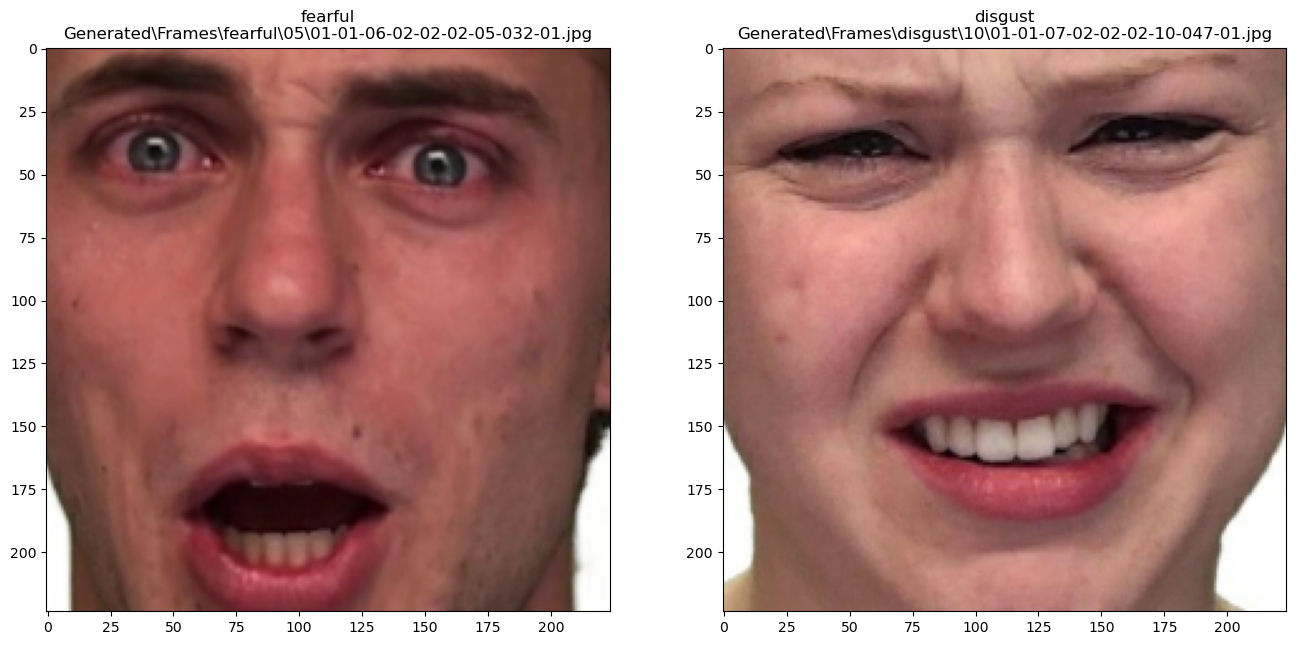

In [198]:
plt.figure(figsize=(16, 10))
cols = 2
rows = int(np.ceil(BATCH_SIZE / cols))

n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    image = example_images[i]
    plt.imshow(image)  # 3 channels
    # plt.imshow(image * 255, cmap='gray', vmin=0, vmax=255)  # 1 channel
    plt.title(f'{labels[example_labels[i]]}\n{train_files[i]}')

---

In [76]:
def create_AlexNet_CNN(name='AlexNet_CNN'):
    model = Sequential([
        Conv2D(
            filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
        ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(
            filters=256, kernel_size=(5, 5), strides=(1, 1), 
            activation='relu', padding="same"
        ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(
            filters=384, kernel_size=(3, 3), strides=(1, 1), 
            activation='relu', padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            filters=384, kernel_size=(3, 3), strides=(1, 1), 
            activation='relu', padding="same"
        ),
        BatchNormalization(),
        Conv2D(
            filters=256, kernel_size=(3, 3), strides=(1, 1), 
            activation='relu', padding="same"
        ),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model._name = name

    return model

In [77]:
def create_Bilotti_CNN(name='Bilotti_CNN'):

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
    conv4 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv4 = Conv2D(18, kernel_size=(3, 3), activation='relu')(pool2)
    conv5 = Conv2D(18, kernel_size=(3, 3), activation='relu')(conv4)
    conv6 = Conv2D(18, kernel_size=(3, 3), activation='relu')(conv5)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)

    conv7 = Conv2D(56, kernel_size=(3, 3), activation='relu')(pool3)
    conv8 = Conv2D(56, kernel_size=(3, 3), activation='relu')(conv7)
    conv9 = Conv2D(56, kernel_size=(3, 3), activation='relu')(conv8)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv9)

    conv10 = Conv2D(51, kernel_size=(3, 3), activation='relu')(pool4)
    conv11 = Conv2D(51, kernel_size=(3, 3), activation='relu')(conv10)
    conv12 = Conv2D(51, kernel_size=(3, 3), activation='relu')(conv11)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv12)

    flatten = Flatten()(pool5)

    dense1 = Dense(2048, activation='relu')(flatten)
    drop1 = Dropout(0.25)(dense1)

    dense2 = Dense(1024, activation='relu')(drop1)
    drop2 = Dropout(0.4)(dense2)

    output = Dense(NUM_CLASSES, activation='softmax')(drop2)

    model = Model(inputs, output)

    model._name = name

    return model

In [78]:
def create_VGG16_Imagenet(name='VGG16_Imagenet'):

    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    )
    base_model.trainable = False  # Not trainable weights

    flatten_layer = Flatten()
    dense_layer_1 = Dense(50, activation='relu')
    dense_layer_2 = Dense(20, activation='relu')
    prediction_layer = Dense(NUM_CLASSES, activation='softmax')

    model = Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        prediction_layer
    ])

    model._name = name

    return model

In [79]:
def create_EfficientNetB0_Imagenet(name='EfficientNetB0_Imagenet'):

    nb_class = NUM_CLASSES

    inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    model = EfficientNetB0(
        include_top=False, input_tensor=inputs, weights="imagenet"
    )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(nb_class, activation="softmax", name="pred")(x)

    model._name = name
    # Compile
    model = Model(inputs, outputs, name="EfficientNet")

    return model

In [51]:
def create_VGG16_VGGFACE(name='VGG16_VGGFACE'):
    nb_class = NUM_CLASSES

    vgg_model = VGGFace(
        include_top=False, weights='vggface', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    )
    vgg_model.trainable = False  # freeze layer
    last_layer = vgg_model.get_layer('pool5').output
    x = Flatten(name='flatten')(last_layer)

    x = Dense(512, activation='relu', name='fc6')(x)
    x = Dropout(0.35)(x)
    x = Dense(256, activation='relu', name='fc7')(x)
    x = Dropout(0.35)(x)
    x = Dense(128, activation='relu', name='fc8')(x)
    x = Dropout(0.35)(x)

    out = Dense(nb_class, activation='softmax', name='fc9')(x)

    custom_vgg_model = Model(vgg_model.input, out)
    custom_vgg_model._name = name

    return custom_vgg_model

In [81]:
def create_RESNET50_VGGFACE(name='RESNET50_VGGFACE'):

    nb_class = NUM_CLASSES

    vgg_model = VGGFace(
        model='resnet50', include_top=False, weights='vggface', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    )
    last_layer = vgg_model.get_layer('avg_pool').output
    x = Flatten(name='flatten')(last_layer)

    x = Dense(512, activation='relu', name='fc6')(x)
    x = Dropout(0.35)(x)
    x = Dense(256, activation='relu', name='fc7')(x)
    x = Dropout(0.35)(x)
    x = Dense(128, activation='relu', name='fc8')(x)
    x = Dropout(0.35)(x)

    out = Dense(nb_class, activation='softmax', name='fc9')(x)

    custom_vgg_model = Model(vgg_model.input, out)
    custom_vgg_model._name = name

    return custom_vgg_model

In [82]:
def create_grigorasi_model(name='vulpe_grigorasi'):

    # 10.1109/ATEE52255.2021.9425073

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    conv1 = Conv2D(256, kernel_size=(3, 3), activation='relu')(inputs)

    conv2 = Conv2D(512, kernel_size=(3, 3), activation='relu')(conv1)
    batch_norm1 = BatchNormalization()(conv2)

    pool1 = MaxPooling2D(pool_size=(2, 2))(batch_norm1)
    drop1 = Dropout(0.4)(pool1)

    conv3 = Conv2D(384, kernel_size=(3, 3), activation='relu')(drop1)
    batch_norm2 = BatchNormalization()(conv3)

    pool2 = MaxPooling2D(pool_size=(2, 2))(batch_norm2)
    drop2 = Dropout(0.4)(pool2)


    conv4 = Conv2D(192, kernel_size=(3, 3), activation='relu')(drop2)
    batch_norm3 = BatchNormalization()(conv4)

    pool3 = MaxPooling2D(pool_size=(2, 2))(batch_norm3)
    drop3 = Dropout(0.4)(pool3)

    conv5 = Conv2D(384, kernel_size=(3, 3), activation='relu')(drop3)
    batch_norm4 = BatchNormalization()(conv5)

    pool4 = MaxPooling2D(pool_size=(2, 2))(batch_norm4)
    drop4 = Dropout(0.4)(pool4)

    flatten = Flatten()(drop4)

    dense1 = Dense(256, activation='relu')(flatten)
    batch_norm5 = BatchNormalization()(dense1)
    drop5 = Dropout(0.3)(batch_norm5)

    output = Dense(NUM_CLASSES, activation='softmax')(drop5)

    model = Model(inputs, output)

    model._name = name

    return model

In [40]:
def create_cnn_model(name='baseline_model'):

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Added
    conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(pool3)
    batch1 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(batch1)

    flatten = Flatten()(pool4)

    dense1 = Dense(256, activation='relu')(flatten)
    drop1 = Dropout(0.4)(dense1)
    output = Dense(NUM_CLASSES, activation='softmax')(drop1)

    model = Model(inputs, output)

    model._name = name

    return model

In [ ]:
def create_dog_vs_cat_model(name='dog_cat'):
    # https://github.com/LinggarM/Dog-vs-Cat-Classification-with-Transfer-Learning-using-VGG16
    vggmodel = VGG16(
        weights='imagenet', include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
    )

    for layers in (vggmodel.layers)[:19]:
        layers.trainable = True

    X = vggmodel.layers[-2].output
    flatten_layer = Flatten()(X)
    # X = Dense(256, activation ='relu')(X)
    # predictions = Dense(1, activation="sigmoid")(flatten_layer)
    predictions = Dense(NUM_CLASSES, activation="softmax")(flatten_layer)
    model_final = Model(vggmodel.input, predictions)

    model_final._name = name

    return model_final

In [46]:
tf.keras.backend.clear_session()  # clear all previous models and sessions

In [ ]:
# model = create_cnn_model()
# model = create_AlexNet_CNN()
# model = medium_model()
# model = create_VGG16_Imagenet()
# model = create_EfficientNetB0_Imagenet()
model = create_VGG16_VGGFACE()
# model = create_grigorasi_model()
# model = create_Bilotti_CNN()
# model = create_RESNET50_VGGFACE()
# model = create_dog_vs_cat_model()
model.summary()

In [101]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

check_path = 'checkpoint.weights.h5'
checkpointer = ModelCheckpoint(
    check_path, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=7, min_lr=0)

In [102]:
METRICS = ['accuracy']

In [103]:
model.compile(
    optimizer=Adam(
        learning_rate=1e-4
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

## Train Model

In [ ]:
EPOCHS = 50
time_callback = TimeHistory()
history = model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[time_callback, early_stopping_callback, checkpointer]
)

In [41]:
EPOCHS = len(time_callback.times)

In [42]:
# Create model path
model_path = Path(const.models_path, 'Frame', model._name)
run_folders = list(Path(const.models_path, 'Frame', model._name).glob('Run_*'))

if not run_folders:
    model_path = Path(model_path, 'Run_1')
else:
    last_run = run_folders.pop()
    last_run_idx = Path(last_run).name.split('_')[-1]
    model_path = Path(model_path, f'Run_{int(last_run_idx) + 1}')

model_path.mkdir(parents=True, exist_ok=False)

In [43]:
# move checkpoint file in folder
if Path(check_path).is_file():
    Path(check_path).rename(Path(model_path, check_path))

In [44]:
notes = ''''''

In [45]:
# ADD NOTES TO FILE (Optional)
if (notes):
    notes_path = Path(model_path, 'note.txt')
    with open(notes_path, 'w+', newline='') as res_file:
        res_file.write(notes)

In [46]:
# Save info on the indexes used for train, val and test
ds_info_path = Path(model_path, 'dataset.csv')
with open(ds_info_path, 'w+', newline='') as res_file:
    filewriter = csv.writer(
        res_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL
    )
    filewriter.writerow(['emotions_label', str(labels)])
    filewriter.writerow(['sampling_rate', str(sampling_rate)])
    filewriter.writerow(['gender_classes', str(gender_classes)])
    filewriter.writerow(['talk_frame', str(talk_frame)])
    filewriter.writerow(['acted_frame', str(acted_frame)])
    filewriter.writerow(['preprocessing', str(preprocess_vgg)])
    filewriter.writerow(['train_indexes', str(train_idxs)])
    filewriter.writerow(['train_files', str(train_ds_elements)])
    filewriter.writerow(['val_indexes', str(val_idxs)])
    filewriter.writerow(['val_files', str(val_ds_elements)])
    filewriter.writerow(['test_indexes', str(test_idxs)])
    filewriter.writerow(['test_files', str(test_ds_elements)])

In [47]:
metrics = history.history

In [48]:
# Save the entire history to a csv
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(metrics)

hist_csv_file = Path(model_path, 'history.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [49]:
mod_loss = metrics['loss']
mod_val_loss = metrics['val_loss']
mod_accuracy = metrics['accuracy']
mod_val_accuracy = metrics['val_accuracy']
# mod_f1 = metrics['fBeta_score']
# mod_val_f1 = metrics['val_fBeta_score']

mod_mean_loss = np.mean(mod_loss)
mod_mean_val_loss = np.mean(mod_val_loss)
mod_mean_accuracy = np.mean(mod_accuracy)
mod_mean_val_accuracy = np.mean(mod_val_accuracy)
# mod_mean_f1 = np.mean(mod_f1)
# mod_mean_val_f1 = np.mean(mod_val_f1)

In [ ]:
# Save Loss
plt.title('Model loss')
plt.plot(history.epoch, mod_loss, mod_val_loss)
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.savefig(Path(model_path, 'loss.png'))

In [ ]:
# Save Accuracy
plt.title('Model accuracy')
plt.plot(
    history.epoch,
    100 * np.array(mod_accuracy),
    100 * np.array(mod_val_accuracy)
)
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.savefig(Path(model_path, 'accuracy.png'))

## Evaluate Model

In [ ]:
model_eval = model.evaluate(test_ds, return_dict=True)

In [53]:
# Save model
model.save(Path(model_path, 'model.keras'), overwrite=False)

# Save model image
model_img = tf.keras.utils.plot_model(
    model, Path(model_path, 'network.png'), show_shapes=True,
    show_layer_names=True, show_layer_activations=True
)

In [54]:
model_eval

{'loss': 0.5292960405349731, 'accuracy': 0.829365074634552}

In [55]:
test_loss = model_eval['loss']
test_accuracy = model_eval['accuracy']
# test_f1 = model_eval['fBeta_score']
mean_epoch_time = np.mean(time_callback.times)

In [56]:
# Save model info
model_save_path = Path(model_path, 'result.csv')

with open(model_save_path, 'w+', newline='') as res_file:
    filewriter = csv.writer(
        res_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL
    )
    filewriter.writerow(['batch_size', BATCH_SIZE])
    filewriter.writerow(['loss_train', str(mod_loss)])
    filewriter.writerow(['loss_val', str(mod_val_loss)])
    filewriter.writerow(['accuracy_train', str(mod_accuracy)])
    filewriter.writerow(['accuracy_val', str(mod_val_accuracy)])
    filewriter.writerow(['loss_test', str(test_loss)])
    filewriter.writerow(['accuracy_test', str(test_accuracy)])
    filewriter.writerow(['mean_epoch_time', str(mean_epoch_time)])

In [57]:
# Save general model csv
with open(Path(const.models_path, 'Frame', 'models.csv'), 'a+') as csvfile:
    filewriter = csv.writer(
        csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL
    )

    # filewriter.writerow(
    #     ["Model Name", "Epochs", "% Validation", "% Test set",
    #      "Train loss", "Train accuracy", "Val loss", "Val accuracy",
    #      "Test loss", "Test accuracy", "Mean epoch time", "Note"]
    # )
    test_ds_perc = utils.trunc((test_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    val_ds_perc = utils.trunc((val_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    full_path = str(Path(model._name, model_path.name))
    filewriter.writerow(
        [full_path, EPOCHS, val_ds_perc, test_ds_perc,
         mod_loss, mod_accuracy, mod_val_loss, mod_val_accuracy,
         test_loss, test_accuracy, mean_epoch_time, '']
    )

In [58]:
for test_images, test_labels in test_ds.take(1):
    print(test_images.shape)
    print(test_labels.shape)

(4, 64, 64, 3)
(4,)


Generated\Frames\sad\22\01-01-04-02-01-02-22-062-01.jpg


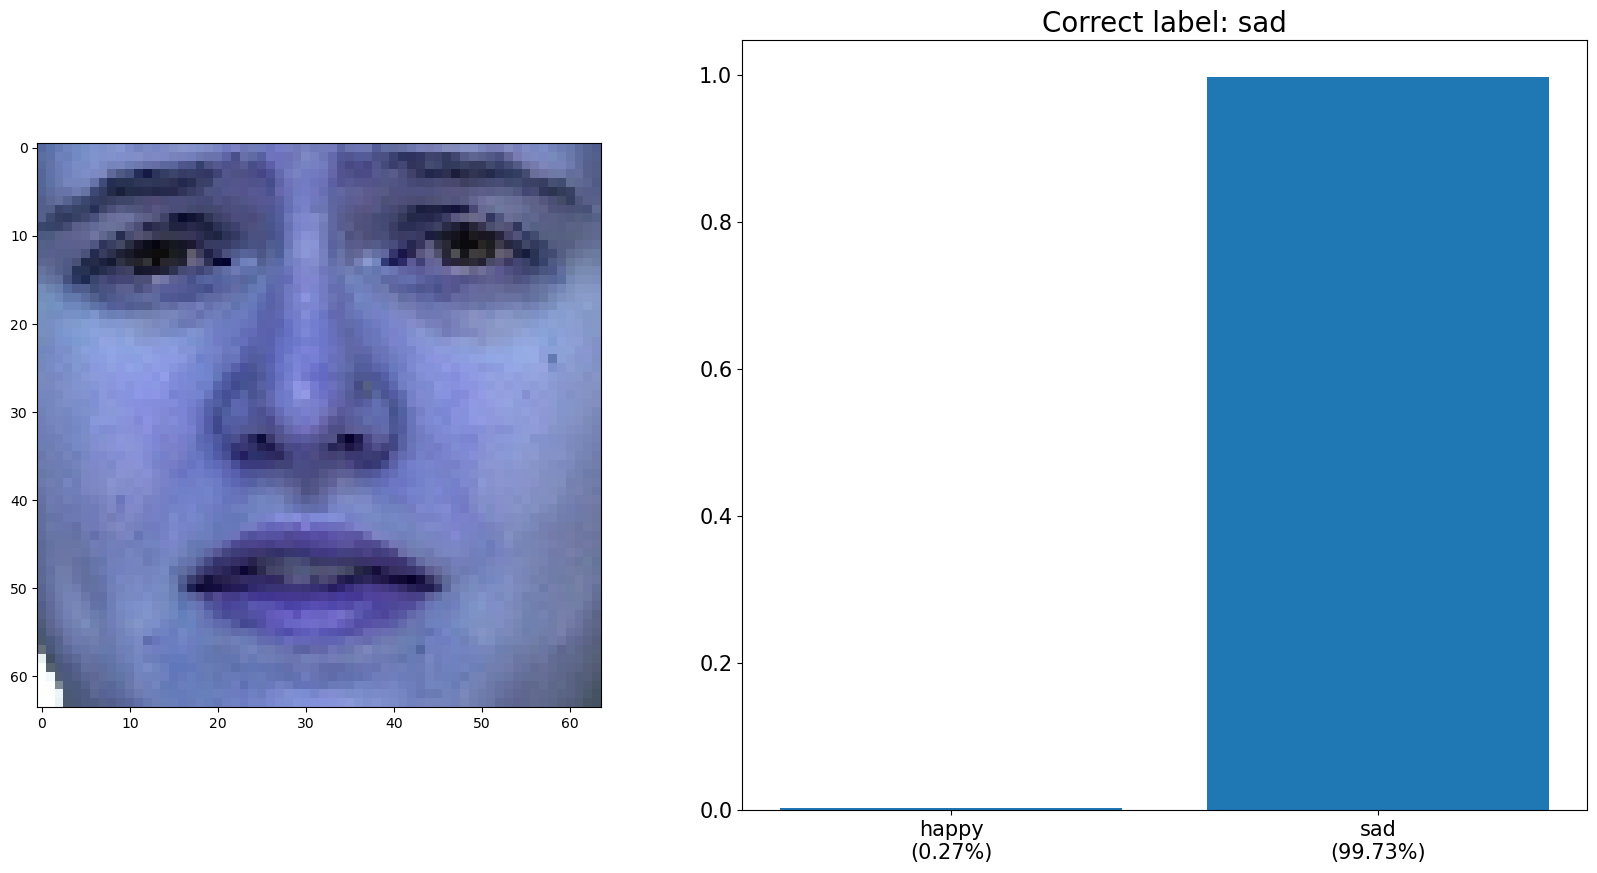

In [59]:
gen = np.random.default_rng(seed=None)
idx = gen.integers(0, len(test_images))
print(test_files[idx])

image = test_images[idx]
label = test_labels[idx]

net_input = utils.extend_tensor(image, 0)
prediction = model(net_input)
prediction = prediction[0].numpy()

valued_arr = []

for idx, name in enumerate(labels):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')
# # valued_arr = [
# #     f'{labels[0]}\n({1-prediction:.2%})',
# #     f'{labels[1]}\n({prediction:.2%})'
# # ]

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

# pltDisplay(image * 255, ax=ax[0])  # 1 channel
pltDisplay(image, ax=ax[0])

# ax[1].bar(valued_arr, [1-prediction, prediction])  # binary - sigmoid
ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {labels[label]}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_ds)

In [61]:
# For multiclass
y_pred = tf.argmax(y_pred, axis=1, output_type=tf.int32)

In [62]:
y_true = tf.concat(list(test_ds.map(lambda _, lab: lab)), axis=0)

In [ ]:
len(y_pred), len(y_true), np.unique(y_pred), np.unique(y_true)

In [64]:
report = classification_report(
    y_true, y_pred, target_names=labels,
    output_dict=True, zero_division='warn'
)

In [65]:
rep_to_csv = pd.DataFrame(data=report).transpose()

In [ ]:
rep_to_csv

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.tick_top()
sns.heatmap(rep_to_csv.iloc[:NUM_CLASSES, :3],
            cbar=True,
            square=False,
            annot=True,
            annot_kws={'size': 15},
            fmt='.2g',
            linewidths=0.5)
plt.savefig(Path(model_path, 'f1_score.png'))
plt.show()


with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(3, 5))
    ax.xaxis.tick_top()
    sns.heatmap(rep_to_csv.iloc[:NUM_CLASSES, 3:],
                cbar=False,
                square=False,
                annot=True,
                annot_kws={'size': 15},
                fmt='.4g',
                cmap=ListedColormap([('xkcd:dark purple', 0.8)]),
                linewidths=0.5)
    plt.savefig(Path(model_path, 'support.png'))
    plt.show()

In [68]:
report_save_path = Path(model_path, 'report.csv')
rep_to_csv.to_csv(report_save_path)

In [69]:
np.mean([report[c]['f1-score'] for c in list(report)[:NUM_CLASSES]])

0.7967093784589986

In [ ]:
# True Test Distribution
# unique, counts = np.unique(y_true, return_counts=True)
# collections.Counter(y_true)
counts = [np.count_nonzero(y_true == idx) for idx in range(len(labels))]
valued_arr = []
# for i in range(len(labels)):
for idx, name in enumerate(labels):
    count = counts[idx]
    valued_arr.append(f'{name}\n({count})')

fig = plt.subplots(figsize=(20, 10))
plt.bar(valued_arr, counts)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test True Distribution', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.savefig(Path(model_path, 'trueDist.png'))
plt.show()

In [ ]:
# Predicted Test Distribution
# unique, counts = np.unique(y_pred, return_counts=True)
counts = [np.count_nonzero(y_pred == idx) for idx in range(len(labels))]
valued_arr = []
unique_idx = 0
for idx, name in enumerate(labels):
    count = counts[idx]
    valued_arr.append(f'{name}\n({count})')

fig = plt.subplots(figsize=(20, 10))
plt.bar(valued_arr, counts)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test result distribution', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.savefig(Path(model_path, 'predDist.png'))
plt.show()

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='.4g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.savefig(Path(model_path, 'heatmap.png'))
plt.show()

In [73]:
def multiclass_roc_auc_score(target, y_test, y_pred, average="macro"):
    # function for scoring roc auc score for multi-class
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    if len(target) > 2:
        for (idx, c_label) in enumerate(target):

            fpr, tpr, thresholds = roc_curve(
                y_test[:, idx].astype(int),
                y_pred[:, idx]
            )
            c_ax.plot(
                fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr))
            )
    else:
        fpr, tpr, thresholds = roc_curve(
                y_test,
                y_pred
        )
        c_ax.plot(
            fpr, tpr, label='Model (AUC:%0.2f)' % (auc(fpr, tpr)), color='#ff7f0e'
        )
    c_ax.plot(fpr, fpr, color='b', linestyle='--', label='Random Guessing')

    return roc_auc_score(y_test, y_pred, average=average)

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(12, 8))

print('ROC AUC score:', multiclass_roc_auc_score(
    labels,
    tf.reshape(y_true, (y_true.shape[0], 1)),
    tf.reshape(y_pred, (y_pred.shape[0], 1))
))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig(Path(model_path, 'ROC.png'))
plt.show()

## Run inference on an image file

Finally, verify the model's prediction output using an image

In [ ]:
# Take the first item of each class in test_files
# path = Path(next((subs for subs in test_files if 'angry' in subs), None))
# path = Path(next((subs for subs in test_files if 'calm' in subs), None))
# path = Path(next((subs for subs in test_files if 'disgust' in subs), None))
# path = Path(next((subs for subs in test_files if 'fearful' in subs), None))
path = Path(next((subs for subs in test_files if 'happy' in subs), None))
# path = Path(next((subs for subs in test_files if 'neutral' in subs), None))
# path = Path(next((subs for subs in test_files if 'sad' in subs), None))
# path = Path(next((subs for subs in test_files if 'surprised' in subs), None))
# path = Path('Generated/Frames/disgust/01-01-07-01-01-01-16-049-01.jpg')
print(path)
# print(tf.io.read_file(str(path)))
label = path.parent.parent.name



# image = cv2.imread(str(path))
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
# image = image / 255
# # image = preprocess_input(image)
image = prep_external_image(str(path), preprocess_vgg)
net_input = utils.extend_tensor(image, 0)
prediction = model(net_input)
# prediction = prediction[0].numpy()[0]  # binary - sigmoid
prediction = prediction[0].numpy()

valued_arr = []

for idx, name in enumerate(labels):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

# valued_arr = [
#     f'{labels[0]}\n({1-prediction[:.2%})',
#     f'{labels[1]}\n({prediction:.2%})'
# ]  # binary - sigmoid


fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)

# # pltDisplay(image * 255, ax=ax[0])  # 1 channel
pltDisplay(image, ax=ax[0])  # 3 channels

ax[1].bar(valued_arr, prediction)
# ax[1].bar(valued_arr, [1-prediction, prediction])  # binary - sigmoid
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {label}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [320]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(
                shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS],
                dtype=tf.float32
            )
        )

    @tf.function
    def __call__(self, x):

        if x.dtype == tf.string:
            x = prep_external_image(x, preprocess_vgg)
            x = utils.extend_tensor(x, 0)

        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(labels, class_ids)
        return {'predictions': result,
                'class_ids': class_ids,
                'class_names': class_names}

Test run the "export" model:

In [321]:
export = ExportModel(model)
img_path = 'calm/05/01-01-02-01-01-01-05-063-01.jpg'
img_path = Path(const.frames_path, img_path)
if img_path.is_file():
    export_res = export(tf.constant(
        str(img_path)
    ))
else:
    raise FileNotFoundError('File not found')

In [322]:
# unpack dictionary
keys, values = zip(*export_res.items())

In [ ]:
prediction = export_res['predictions'][0].numpy()

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({prediction[idx]:.2%})')

fig, ax = plt.subplots(
    nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
)
print(img_path)
# image = cv2.imread(str(Path(const.frames_path, img_path)))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
image = prep_external_image(str(img_path), preprocess_vgg)
pltDisplay(image / 255, ax=ax[0])


ax[1].bar(valued_arr, prediction)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {str(Path(img_path).parent.parent)}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

In [ ]:
E2E_model_path = Path(model_path, 'E2E/')
tf.saved_model.save(export, E2E_model_path)
imported = tf.saved_model.load(E2E_model_path)

imported_res = imported(tf.constant(str(img_path)))

In [325]:
np.array_equal(export_res['predictions'].numpy(), imported_res['predictions'].numpy())

True

In [ ]:
command = f'jupyter nbconvert --to html FacialEmotionRecognition.ipynb --output {str(Path(model_path, "notebook.html"))}'
subprocess.run(command, capture_output=True, shell=True)

--------------